# Preprocessing data

### Imports

In [29]:
import os
from preprocessors.edfpreprocessor import EDFPreprocessorAcc as edfaccpp
from preprocessors.edfpreprocessor import EDFPreprocessorECG as edfecgpp
from preprocessors.avropreprocessor import AvroAcc as avroaccpp
from preprocessors.oepreprocessor import OEPreprocessor as oepp
from preprocessors.concat_avro import AvroMerger
from sync.synchotron import synchotron
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path

In [34]:
participant_id = "pilotp07"

In [35]:
# load directories and file paths, merge avro files if not already done
parentdir = "data"
path = os.path.join(parentdir, participant_id)

OELpath = os.path.join(path, "Pilot07Lmicremoved.oe")
OERpath = os.path.join(path, "Pilot07R.oe")
EDFpath = os.path.join(path, "P07.edf")
avro_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".avro"):
            avro_files.append(os.path.join(root, file))

merged_avro_output_path = os.path.join(path, f"{participant_id}_merged.avro")
if not os.path.exists(merged_avro_output_path):
    avromerger = AvroMerger(avro_files)
    avromerger.merge_avro_files(merged_avro_output_path)



[OK] Merged Avro file written to: data\pilotp07\pilotp07_merged.avro


In [36]:
# load data using preprocessors
oedataL = oepp(OELpath).load()
oedataR = oepp(OERpath).load()
edfaccdata = edfaccpp(EDFpath).load()
edfecgdata = edfecgpp(EDFpath).load()
avroaccdata = avroaccpp(merged_avro_output_path).load()
print("Data loaded successfully.")

📂 File: Pilot07Lmicremoved.oe, Version: 1, Timestamp: 1971-04-21 15:49:13
📂 File: Pilot07R.oe, Version: 1, Timestamp: 1970-09-26 11:27:20
read -1, less than 519400 requested!!!
read -1, less than 519400 requested!!!
Data loaded successfully.


Calculated sample rate: 64.00676727591598 Hz
Calculated sample rate: 99.99999999999994 Hz
Calculated sample rate: 49.95121888164106 Hz
Calculated sample rate: 49.945770085444174 Hz
Extracted window from index 5095 to 5415 (1s before and 4s after first 95% max point)
Extracted window from index 510677 to 511175 (1s before and 4s after first 95% max point)
Extracted window from index 33 to 281 (1s before and 4s after first 95% max point)
Extracted window from index 32 to 280 (1s before and 4s after first 95% max point)


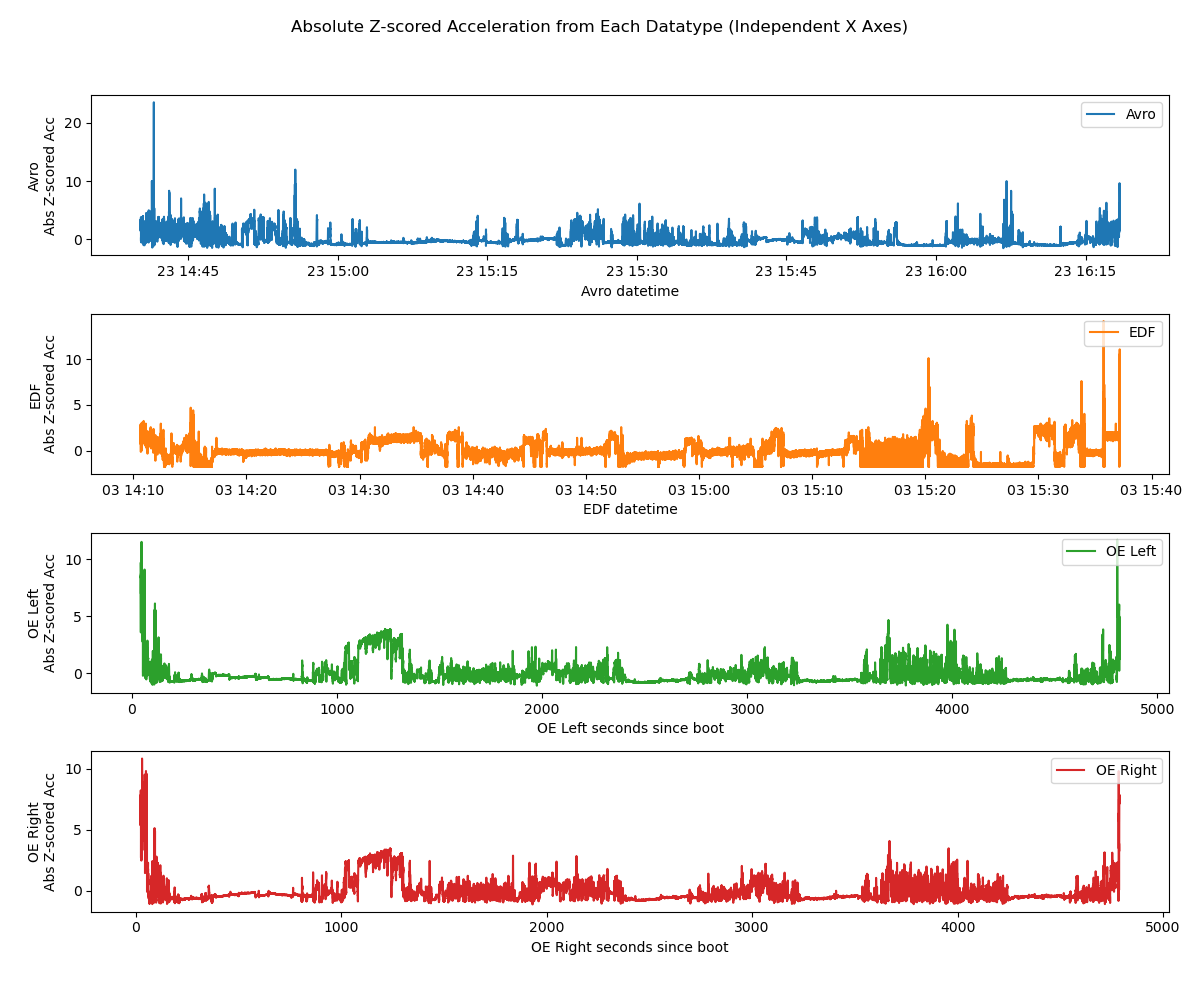

In [37]:
# syncing data

syncer = synchotron(
    avroaccdata,
    edfaccdata,
    oedataL,
    oedataR,
)
syncer.plot_unsynced()


Use this plot and inspect to find the time ranges to search for for the jumps, and then provide this to the synchronisation function.
Matplotlib has been configured in this notebook so that there is a tool in the tab on the left, 'zoom to rectangle' 

Calculated sample rate: 64.00676727591598 Hz
Calculated sample rate: 99.99999999999994 Hz
Calculated sample rate: 49.95121888164106 Hz
Calculated sample rate: 49.945770085444174 Hz
Using manual datetime window: 2025-10-31 14:51:40 → 2025-10-31 14:51:49
Using manual datetime window: 2025-10-31 12:51:30 → 2025-10-31 12:51:38
Using manual timestamp window: 108.000s → 115.000s
Using manual timestamp window: 89.000s → 95.000s


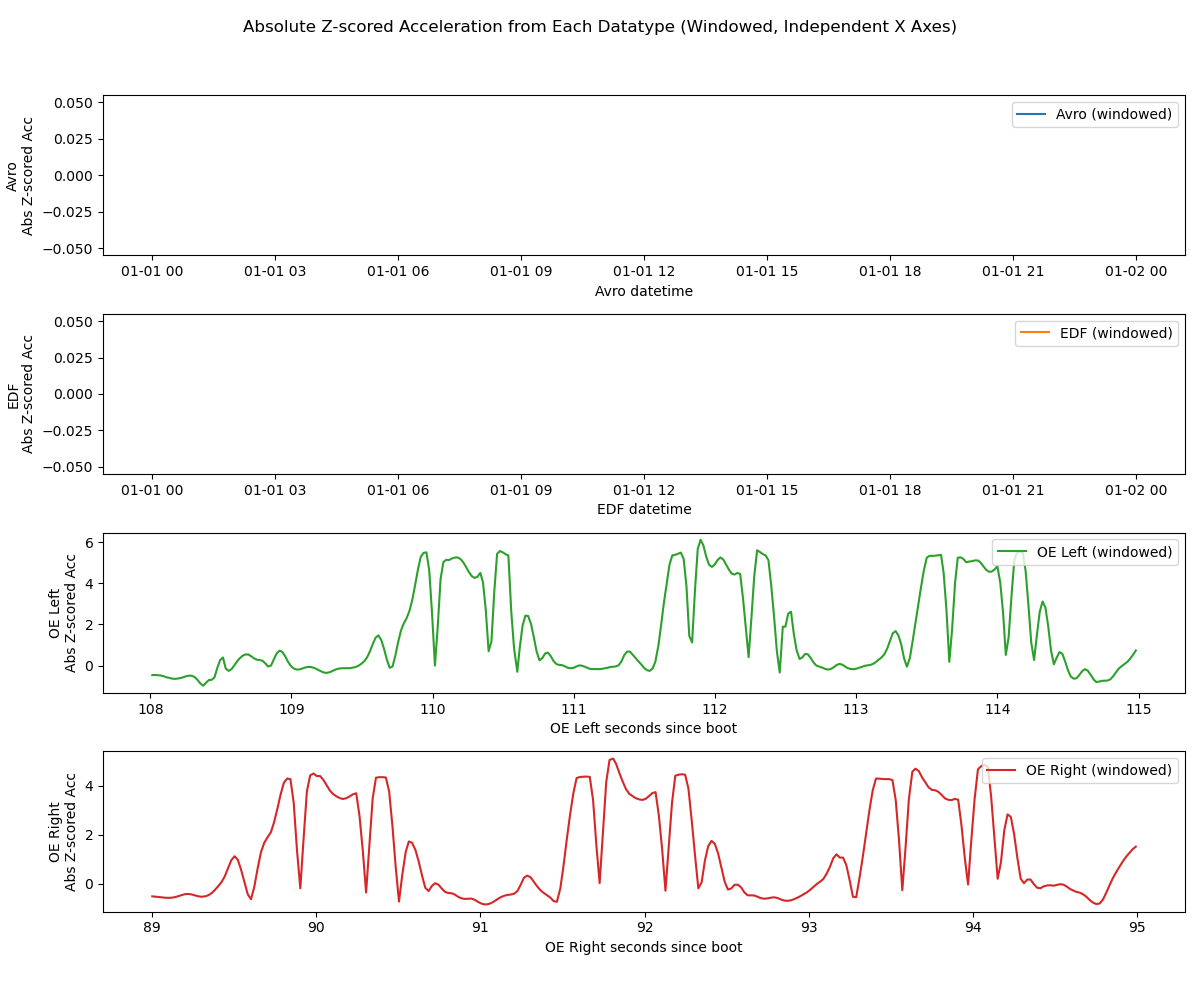

IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:

# will recall and instantiate the syncer object with the new parameters including the manually defined windows
edf_window = ("2025-10-31 12:51:30", "2025-10-31 12:51:38") # this is correct for P05
avro_window = ("2025-10-31 14:51:40", "2025-10-31 14:51:49") # need to get the correct avro data for P05 empatica 
oeLwindow = (108, 115)  
oeRwindow = (89, 95) 
 
syncer = synchotron(
    avroaccdata,
    edfaccdata,
    oedataL,
    oedataR,
    edf_window=edf_window,
    avro_window=avro_window,
    oeL_window=oeLwindow,
    oeR_window=oeRwindow,
)

syncer.plot_windowed()

avro_shift, oeL_shift, oeR_shift = syncer.sync()

## Great! Sync verification complete

Though this does not yet fully timestamp and shift the data to be aligned, as long as we can identify the synchronisation jumps in the data and align them as we have in this notebook, then we know that it can be done for these data types. 

Now we can take a look at some of the data  and check the integrity

First lets do PPG on the ear

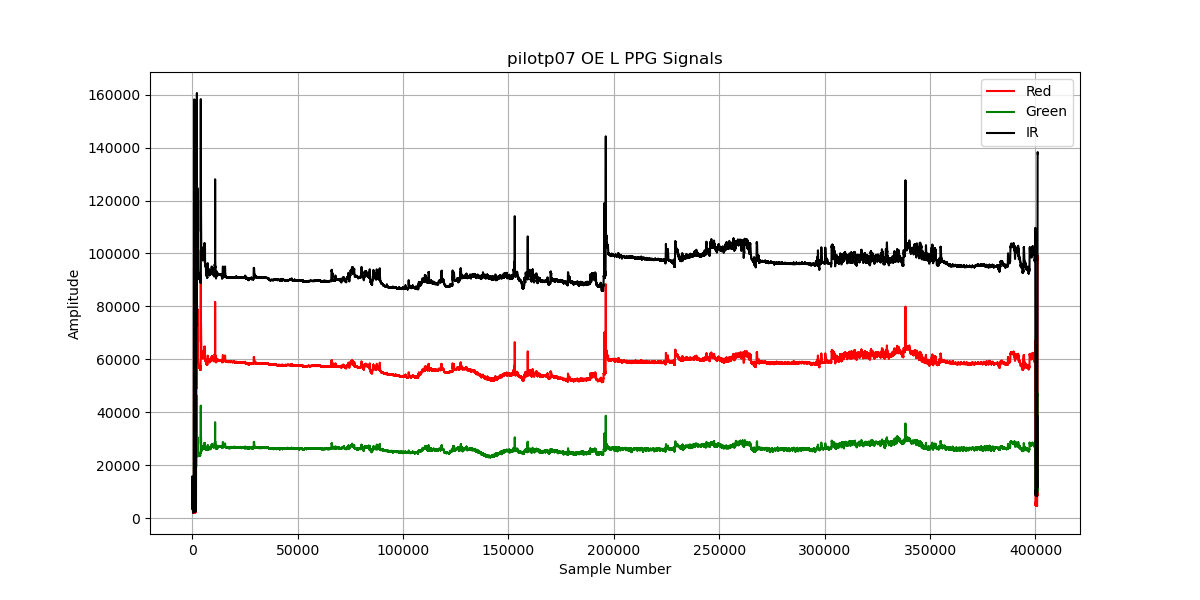

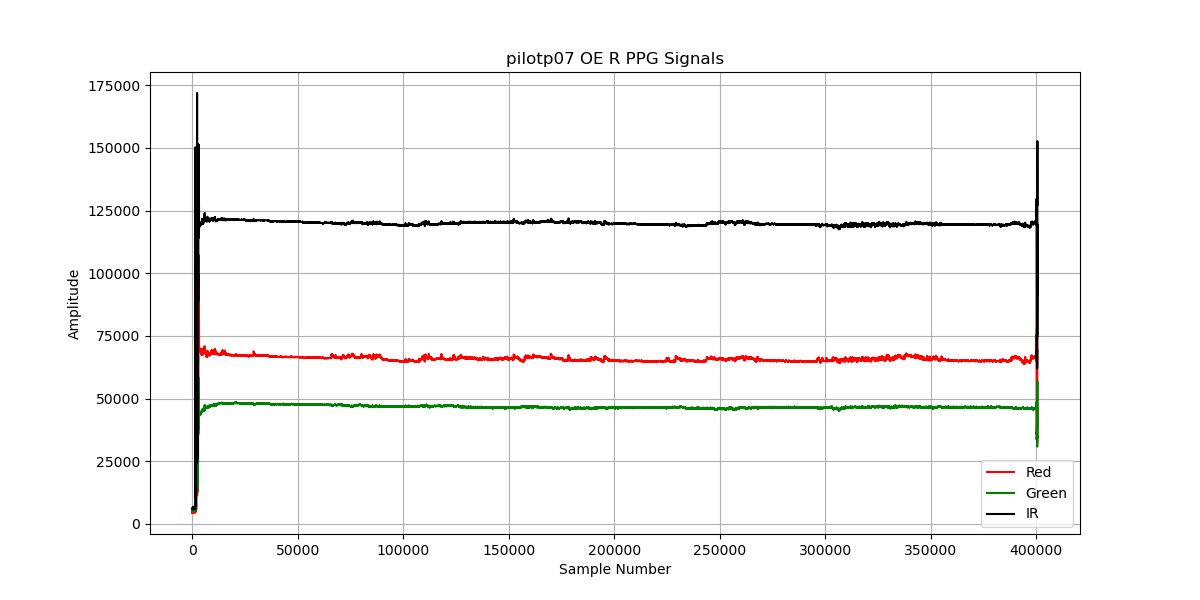

In [39]:

def plot_ppg_signals(oedata, participant_id, label=""):
    """Plot red, green, and IR PPG signals from a given oedata structure."""
    ppg_red = np.asarray(oedata["ppg"]["red"].values)
    ppg_green = np.asarray(oedata["ppg"]["green"].values)
    ppg_ir = np.asarray(oedata["ppg"]["ir"].values)

    x = np.arange(ppg_red.shape[0])

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x, ppg_red, color="red", label="Red")
    ax.plot(x, ppg_green, color="green", label="Green")
    ax.plot(x, ppg_ir, color="black", label="IR")
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{participant_id} {label} PPG Signals")
    ax.legend()
    ax.grid(True)
    plt.show()

# Example usage:
plot_ppg_signals(oedataL, participant_id, label="OE L")
plot_ppg_signals(oedataR, participant_id, label="OE R")

# To Do

## Avro
All aspects will need an integrity check in this notebook

## EDA
No EDA processing from shimmer is done at the moment as a late addition to the project

## Temp
Temperature is verified as we can see the graph when we download it from the iButtons. But we should add here for completeness.

## Respiration rate
p05s trial the respiban failed, so nothing to plot here, but a quick plotter would be useful. 